In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skan import csr
from skimage import io, color, morphology

def show(imaje):
    # plt.figure(figsize=(8, 8))
    plt.imshow(imaje, cmap='gray')
    plt.show()

img_path = 'maple/1.png'
img = io.imread(img_path)
if img.shape[2] == 4:
    alpha_threshold = 0.01  # Define a threshold for alpha values
    nearly_transparent = img[:, :, 3] < alpha_threshold * 255
    img[nearly_transparent] = [0, 0, 0, 255]  # Set the color to red with full opacity

if img.shape[2] == 4:
    # Discard the alpha channel
    img = img[:, :, :3]

img_gray = color.rgb2gray(img)

threshold = np.mean(img_gray)
img_binary = img_gray > threshold



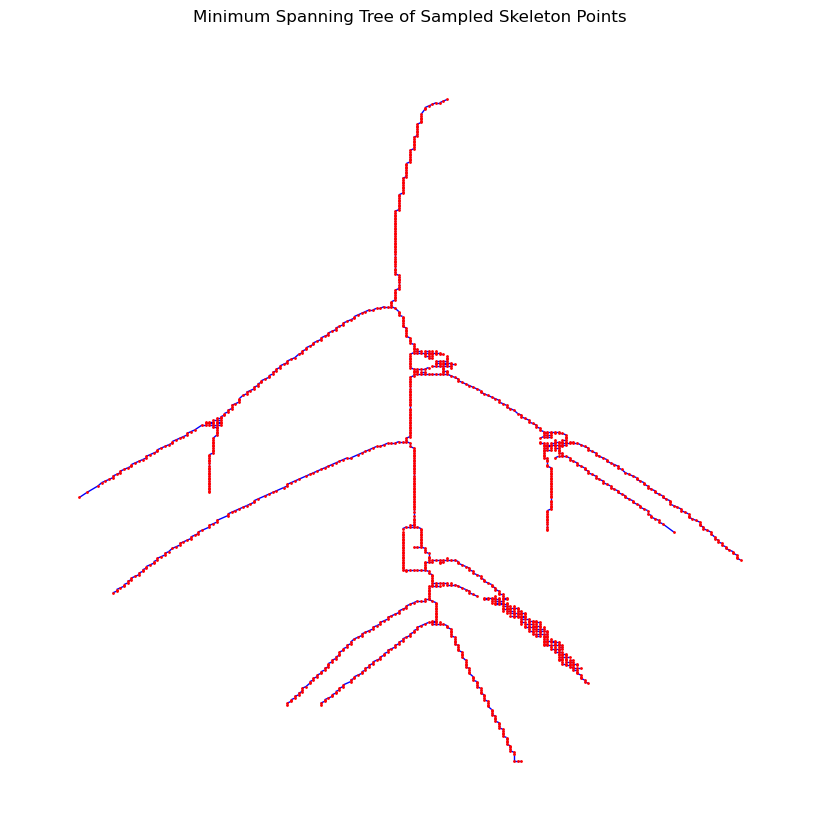

In [23]:
from skimage import io, color, morphology
from skimage.morphology import binary_dilation, binary_erosion, binary_closing
skeleton = morphology.skeletonize(img_binary)

selem = np.ones((3, 3))

skeleton_dilated = binary_dilation(skeleton, selem)
skeleton_cleaned = binary_erosion(skeleton_dilated, selem)
skeleton_closed = binary_closing(skeleton_cleaned, selem)

# # Draw the nodes with the specified size
# plt.imshow(skeleton)

# Flatten the skeleton to get all foreground pixel coordinates
skeleton_coords = np.column_stack(np.where(skeleton_cleaned))

# Calculate the number of points to sample (99% of all points)
num_sample = int(len(skeleton_coords) * 0.95)

# Randomly sample the points
sampled_coords = skeleton_coords[np.random.choice(len(skeleton_coords), num_sample, replace=False)]

# # Plot the original skeleton image
# plt.figure(figsize=(8, 8))
# plt.imshow(img, cmap='gray')

# # Overlay the sampled points on the skeleton image
# plt.scatter(sampled_coords[:, 1], sampled_coords[:, 0], c='r', s=1)  # Use red color for the sampled points

# # Show the plot with the sampled points
# plt.title('Sampled Skeleton Points')
# plt.show()

import networkx as nx
G = nx.Graph()

# Add points to the graph
for coord in sampled_coords:
    G.add_node(tuple(coord), pos=(coord[1], coord[0]))

# Since we are only adding nodes and not connecting them with edges,
# the graph will consist of unconnected nodes.

# # Now, let's visualize the graph with the pos attribute
# plt.figure(figsize=(8, 8))
# # plt.imshow(img, cmap='gray')

# # Extract positions from the graph
# pos = nx.get_node_attributes(G, 'pos')

# # Draw only the nodes (since there are no edges)
# nx.draw_networkx_nodes(G, pos, node_size=1, node_color='r')

# plt.title('Graph of Sampled Skeleton Points')
# plt.show()


# First, connect the nodes with edges. This example uses Euclidean distance between points.
for i, source in enumerate(sampled_coords):
    for target in sampled_coords[i+1:]:
        # Calculate Euclidean distance between source and target
        distance = np.linalg.norm(source - target)
        # Add an edge with the distance as weight
        G.add_edge(tuple(source), tuple(target), weight=distance)

# Now compute the minimum spanning tree of G
mst = nx.minimum_spanning_tree(G)

# Visualize the minimum spanning tree
plt.figure(figsize=(8, 8))
# plt.imshow(img, cmap='gray')

# Get positions from the original graph G
pos = nx.get_node_attributes(G, 'pos')

# Draw the MST
nx.draw(mst, pos, with_labels=False, node_size=1, node_color='r', edge_color='b')

plt.title('Minimum Spanning Tree of Sampled Skeleton Points')
plt.show()


# csr_skeleton = csr.Skeleton(skeleton)

# import networkx as nx

# # Initialize a new graph
# G = nx.Graph()

# Iterate over the skeleton paths to add edges to the graph
# for i in range(csr_skeleton.paths.indptr.shape[0] - 1):
#     path = csr_skeleton.path(i)
#     for (source, target) in zip(path[:-1], path[1:]):
#         # Add an edge to the graph if it doesn't exist already
#         if not G.has_edge(source, target):
#             G.add_edge(source, target)


# # Assuming G has been created as shown in the previous code snippet

# # Extract the positions of the nodes for visualization
# # The positions are usually the (row, column) indices of the pixels in the image
# # pos = {node: (G.nodes[node][1], G.nodes[node][0]) for node in G.nodes}

# # Draw the graph
# plt.figure(figsize=(8, 8))
# nx.draw(G, node_size=10, node_color='red', edge_color='black')

# # Show the plot
# plt.show()
# Now G contains the graph representation of the skeleton

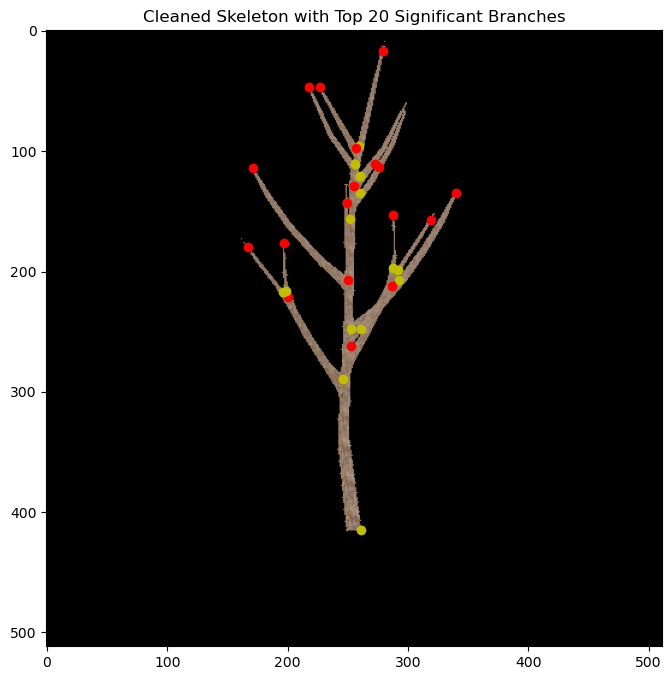

In [8]:
skeleton = morphology.skeletonize(img_binary)
csr_skeleton = csr.Skeleton(skeleton)
import networkx as nx
import matplotlib.pyplot as plt


skeleton = morphology.skeletonize(img_binary)

skeleton_graph = csr.Skeleton(skeleton)

branches = [skeleton_graph.path_coordinates(i) for i in range(skeleton_graph.paths.indptr.shape[0] - 1)]
branch_lengths = [np.linalg.norm(branch[-1] - branch[0]) for branch in branches]
sorted_indices = np.argsort(branch_lengths)[::-1]

N = 20
significant_branches = [branches[i] for i in sorted_indices[:N]]

# print(img_path)
# if '1' in img_path:
#     # plt.imshow(img)
#     plt.figure(figsize=(8, 8))
#     plt.imshow(skeleton_cleaned, cmap='gray')
#     # plt.imshow()
#     plt.show()

edges = []

plt.figure(figsize=(8, 8))
plt.imshow(img)
for i, branch in enumerate(significant_branches):
    plt.scatter(branch[0, 1], branch[0, 0], c='r')  # Head pixel
    plt.scatter(branch[-1, 1], branch[-1, 0], c='y')  # Tail pixel
    head = (branch[0, 1], branch[0, 0])
    tail = (branch[-1, 1], branch[-1, 0])
    edges.append((head, tail))
if '1' in img_path:
    plt.title('Cleaned Skeleton with Top {} Significant Branches'.format(N))
    plt.show()


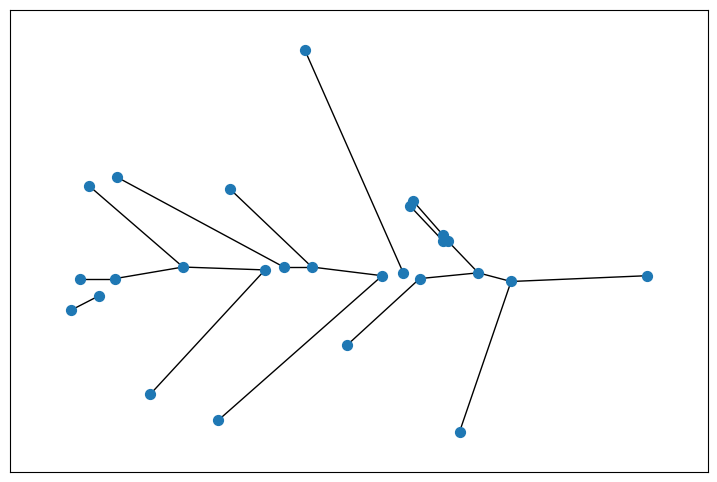

In [14]:
G = nx.Graph()
edges = [(tuple(edge[0]), tuple(edge[-1])) for edge in edges]


pos = {node: (np.cos(np.radians(270))*node[0] - np.sin(np.radians(270))*node[1], 
                np.sin(np.radians(270))*node[0] + np.cos(np.radians(270))*node[1]) for edge in edges for node in edge}

x_values = [x for x, y in pos.values()]
y_values = [y for x, y in pos.values()]
x_min, x_max = min(x_values), max(x_values)
y_min, y_max = min(y_values), max(y_values)

pos = {node: ((x - x_min) / (x_max - x_min), (y - y_min) / (y_max - y_min)) for node, (x, y) in pos.items()}

G.add_edges_from(edges)

plt.figure(figsize=(9, 6))

# Draw the nodes with the specified size
nx.draw_networkx_nodes(G, pos, node_size=50)
nx.draw_networkx_edges(G, pos)


# Omit drawing the edges and labels

# Show the plot
plt.show()